# Harnessing Data Science to Enhance Garment Manufacturing Productivity: Insights from Decision Trees and Gradient Boosting

In the competitive landscape of garment manufacturing, team productivity is a pivotal factor that directly influences operational efficiency and business success. This project leverages machine learning to predict the productivity performance of working teams in this sector. Utilizing a comprehensive dataset encompassing 15 variables and 1197 instances, this analysis provides valuable insights into the factors that drive productivity in garment manufacturing.

Our goal is to develop a predictive model that accurately forecasts whether a team will meet or exceed its target productivity, aiding managerial decisions in optimizing workforce efficiency. To achieve this, we employed various machine learning techniques, including Decision Trees, Random Forests, and Gradient Boosting Classifiers, refined through cross-validated hyperparameter tuning. The exploration and preprocessing of the data involved outlier removal, feature engineering, and missing value imputation using a KNN imputer.

Key findings reveal that the amount of financial incentive, the standard minute value (SMV), and the team size significantly influence productivity outcomes. Intriguingly, our analysis indicates that while increasing financial incentives and team size initially boosts the likelihood of achieving productivity targets, this effect plateaus beyond a certain threshold. Conversely, a higher allocated time for a task correlates with a marginally reduced probability of meeting the target. 

With an 82% accuracy achieved by the Gradient Boosting Classifier and a notable 64% precision by the Decision Tree in predicting productivity shortfalls, our results offer actionable insights for tailoring workforce strategies. The selection of the most suitable model hinges on the specific business objectives, underscoring the importance of aligning analytical approaches with organizational goals.

---

Source of data:
https://archive.ics.uci.edu/dataset/597/productivity+prediction+of+garment+employees

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import matplotlib.style as style

style.use('seaborn-v0_8-muted')

In [3]:
garments = pd.read_csv('garments_worker_productivity.csv')

garments

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,3/11/2015,Quarter2,finishing,Wednesday,10,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.628333
1193,3/11/2015,Quarter2,finishing,Wednesday,8,0.70,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1194,3/11/2015,Quarter2,finishing,Wednesday,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1195,3/11/2015,Quarter2,finishing,Wednesday,9,0.75,2.90,NaN,1800,0,0.0,0,0,15.0,0.505889


## Exploratory Data Analysis

In [4]:
garments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

- Wip variable (work in progress, number of unfinished items for products) is missing half of values.
- Date variable needs to be broken down into its constituent parts (day, month, year).
- New day variable (extracted from date) is correlated with quarter, we can then drop the quarter column.

In [5]:
garments.wip.describe()

count      691.000000
mean      1190.465991
std       1837.455001
min          7.000000
25%        774.500000
50%       1039.000000
75%       1252.500000
max      23122.000000
Name: wip, dtype: float64

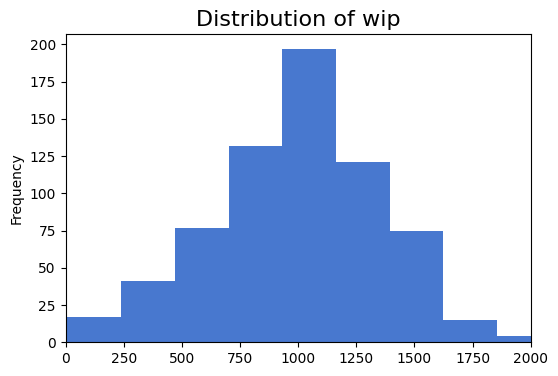

In [58]:
plt.figure(figsize=(6,4))
garments.wip.plot.hist(bins=100)
plt.title('Distribution of wip', size=16)
plt.xlim([0, 2000])
plt.show()

In [7]:
pd.qcut(garments.wip.dropna(), q=20)

0       (1073.0, 1108.0]
2         (944.0, 991.0]
3         (944.0, 991.0]
4       (1141.5, 1193.0]
5         (944.0, 991.0]
              ...       
1187    (1039.0, 1073.0]
1188     (991.0, 1039.0]
1189      (897.5, 944.0]
1190    (1108.0, 1141.5]
1191      (897.5, 944.0]
Name: wip, Length: 691, dtype: category
Categories (20, interval[float64, right]): [(6.999, 358.5] < (358.5, 532.0] < (532.0, 626.5] < (626.5, 711.0] ... (1313.0, 1396.5] < (1396.5, 1484.0] < (1484.0, 1602.0] < (1602.0, 23122.0]]

Most of the non-missing wip values are distributed very close to the mean, in fact 95% of the values are within 1 standard deviation. We will replace the missing values later.

In [8]:
garments.day.value_counts()

Wednesday    208
Sunday       203
Tuesday      201
Thursday     199
Monday       199
Saturday     187
Name: day, dtype: int64

No observations are made on Fridays.

In [9]:
garments.department.value_counts()

sweing        691
finishing     257
finishing     249
Name: department, dtype: int64

Department names need to be cleaned up and can be converted to binary.

In [10]:
garments.describe()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197.000000,1197.000000,1197.000000,691.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091
std,3.463963,0.097891,10.943219,1837.455001,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.174488
min,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,3.000000,0.700000,3.940000,774.500000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,6.000000,0.750000,15.260000,1039.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,9.000000,0.800000,24.260000,1252.500000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253
max,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437


There are several sparse features (incentive, idle time, idle men, number of style changes).

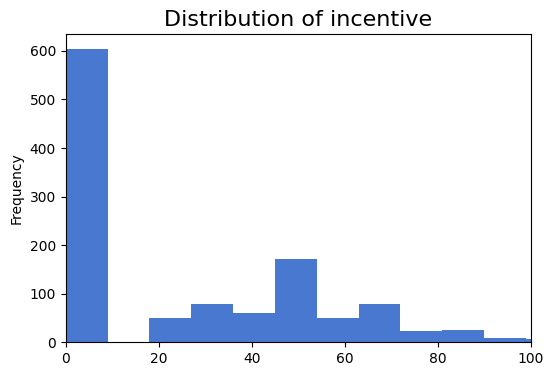

In [59]:
plt.figure(figsize=(6,4))
garments.incentive.plot.hist(bins=400)
plt.xlim([0, 100])
plt.title('Distribution of incentive', size=16)
plt.show()

There is variability in non-zero incentive data, so we will leave this feature unchanged.

In [12]:
garments.idle_time.value_counts()

0.0      1179
3.5         3
2.0         2
5.0         2
8.0         2
4.5         2
4.0         2
90.0        1
150.0       1
270.0       1
300.0       1
6.5         1
Name: idle_time, dtype: int64

In [13]:
garments.idle_men.value_counts()

0     1179
10       3
15       3
30       3
20       3
35       2
45       1
37       1
25       1
40       1
Name: idle_men, dtype: int64

In [14]:
((garments.idle_men == 0) & (garments.idle_time == 0)).sum()

1179

We will combine the columns and convert the new one to binary, where 1 indicates an interruption in production, resulting in idle men and time.

In [15]:
garments.no_of_style_change.value_counts()

0    1050
1     114
2      33
Name: no_of_style_change, dtype: int64

This feature will as well be unchanged.

In [16]:
garments.targeted_productivity.value_counts()

0.80    540
0.70    242
0.75    216
0.65     63
0.60     57
0.50     49
0.35     27
0.40      2
0.07      1
Name: targeted_productivity, dtype: int64

There could be an outlier, an observation with an unlikely 7% level of target productivity.

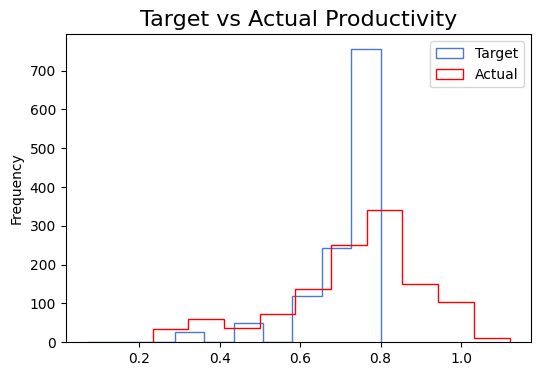

In [74]:
plt.figure(figsize=(6,4))
garments.targeted_productivity.plot.hist(histtype='step', label='Target')
garments.actual_productivity.plot.hist(histtype='step', color='r', label='Actual')
plt.title('Target vs Actual Productivity', size=16)
plt.legend()
plt.show()

Actual productivity is bell-shaped with fat tails, while the target is concentrated in the 60-80% range. We will create a new column based on whether the productivity target set by management has been achieved and set it as the new response.

## Data Cleaning

First, we will drop the outlier from Target productivity and form the new response variable. Second, we will clean up the Department column and drop the Quarter column. Next, we will split Date into three new columns. Then we will merge Idle columns into the new one. Finally, we will convert all categorical variables with one-hot encoding and impute missing values for Wip with a KNN imputer.

### Forming new response

In [169]:
# Dropping the outlier
garments1 = garments[garments['targeted_productivity'] > 0.1]

# Extracting columns for response
y = garments1[['targeted_productivity', 'actual_productivity']].copy()

# Creating new response
y['target_missed'] = y['actual_productivity'] - y['targeted_productivity']

#y['target'] = y['target'].apply(lambda x: 'Met' if x >= 0 else 'Missed')
y['target_missed'] = y['target_missed'].apply(lambda x: 0 if x >= 0 else 1)

y = y['target_missed']

y

0       0
1       0
2       0
3       0
4       0
       ..
1192    1
1193    1
1194    1
1195    1
1196    1
Name: target_missed, Length: 1196, dtype: int64

In [170]:
y.value_counts()

0    874
1    322
Name: target_missed, dtype: int64

We are interested in the overall accuracy of a model and the predictive power for cases where the target was missed (about 1/4 of the data).

### Cleaning Quarter and Department features

In [70]:
X = garments1.drop(['quarter', 'targeted_productivity', 'actual_productivity'], axis=1).copy()


X['department'] = X['department'].apply(lambda x: 'sewing' if x == 'sweing' else 'finishing')

### Breaking down Date column

In [71]:
X['date_d'] = pd.to_datetime(X['date']).dt.day

X['date_m'] = pd.to_datetime(X['date']).dt.month

X['date_y'] = pd.to_datetime(X['date']).dt.year

X = X.drop(['date'], axis=1)

We will examine the new columns.

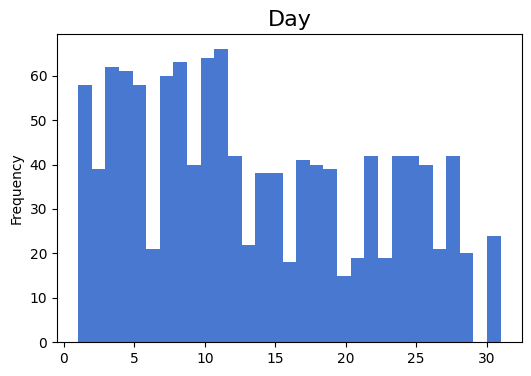

In [75]:
plt.figure(figsize=(6,4))
X['date_d'].plot.hist(bins=31)
plt.title('Day', size=16)
plt.show()

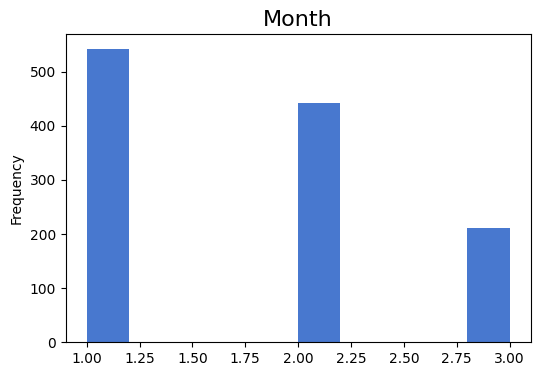

In [77]:
plt.figure(figsize=(6,4))
X['date_m'].plot.hist()
plt.title('Month', size=16)
plt.show()

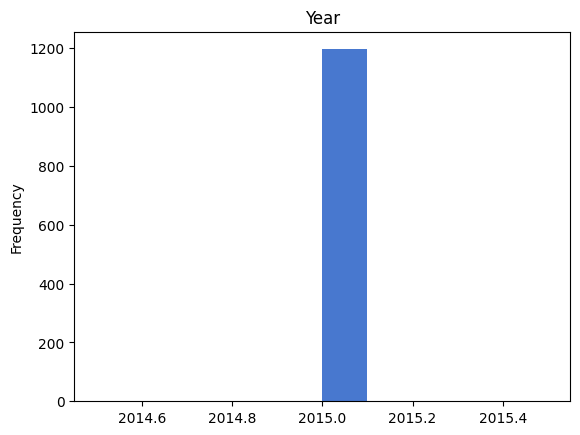

In [25]:
X['date_y'].plot.hist()
plt.title('Year')
plt.show()

Since the observations were made only in the first quarter of 2015, we can drop the year column.

In [78]:
X = X.drop(['date_y'], axis=1)

### Combining Idle columns

In [79]:
X['idle'] = X['idle_time'] + X['idle_men']

X = X.drop(['idle_time', 'idle_men'], axis=1)

X['idle'] = X['idle'].apply(lambda x: 0 if x == 0 else 1)

### Converting categorical variables

In [80]:
X = pd.get_dummies(X, drop_first=True)

### Imputing missing values for wip

In [29]:
from sklearn.impute import KNNImputer

In [81]:
imp_knn = KNNImputer(n_neighbors=5)

X = pd.DataFrame(imp_knn.fit_transform(X), columns=X.columns)

X

,team,smv,wip,over_time,incentive,no_of_style_change,no_of_workers,date_d,date_m,idle,department_sewing,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,8.0,26.16,1108.0,7080.0,98.0,0.0,59.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1.0,3.94,994.4,960.0,0.0,0.0,8.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,11.0,11.41,968.0,3660.0,50.0,0.0,30.5,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,12.0,11.41,968.0,3660.0,50.0,0.0,30.5,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,6.0,25.90,1170.0,1920.0,50.0,0.0,56.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,10.0,2.90,994.4,960.0,0.0,0.0,8.0,11.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1192,8.0,3.90,994.4,960.0,0.0,0.0,8.0,11.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1193,7.0,3.90,994.4,960.0,0.0,0.0,8.0,11.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1194,9.0,2.90,632.8,1800.0,0.0,0.0,15.0,11.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


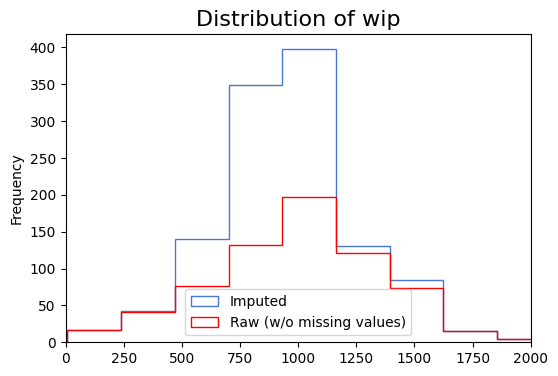

In [82]:
plt.figure(figsize=(6,4))
X['wip'].plot.hist(bins=100, histtype='step', label='Imputed')
garments1['wip'].dropna().plot.hist(bins=100, histtype='step', color='r', label='Raw (w/o missing values)')
plt.xlim([0, 2000])
plt.title('Distribution of wip', size=16)
plt.legend()
plt.show()

## Building the Decision Tree

We will start by fitting a decision tree classifier.

In [94]:
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             ConfusionMatrixDisplay)
import sklearn.model_selection as skm

In [83]:
feature_names = list(X.columns)
X = np.asarray(X)

In [171]:
X_train, X_test, y_train, y_test = skm.train_test_split(X, y,
                                   test_size=0.2,
                                   random_state=20)

In [172]:
print(y_train.value_counts(normalize=True),'\n'*2,
      y_test.value_counts(normalize=True))

0    0.733264
1    0.266736
Name: target_missed, dtype: float64 

 0    0.720833
1    0.279167
Name: target_missed, dtype: float64


The response is evenly distributed across the training and test sets. Since the dominant class comprises 72% of all values in the test set, a simple classifier that always predicts this class will have an accuracy of 72%, so it will be our basic benchmark for comparison. Correspondingly, our benchmark for precision would be 28%.

In [249]:
eval_metrics = pd.DataFrame(index=['Accuracy', 'Precision'])
eval_metrics['Benchmark'] = [0.72, 0.28]

eval_metrics

,Benchmark
Accuracy,0.72
Precision,0.28


In [208]:
clf = DTC(criterion='entropy',
          max_depth=5,
          random_state=20, min_samples_split=5)

clf.fit(X_train, y_train)

clf_acc = accuracy_score(y_test, clf.predict(X_test))
clf_acc

0.7666666666666667

Classification tree yields accuracy of 77%, which is better than the baseline.

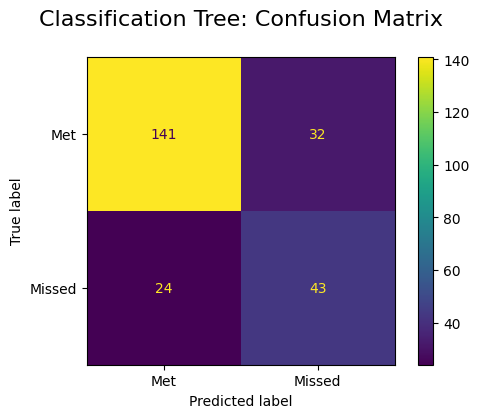

In [190]:
fig, ax = plt.subplots(figsize=(6, 4))
display = ConfusionMatrixDisplay.from_predictions(y_test, clf.predict(X_test), ax=ax,
                                                 display_labels=class_names)
plt.title('Classification Tree: Confusion Matrix'+'\n', size=16)
plt.show()

In [250]:
eval_metrics['Tree'] = [clf_acc, 43/67]
eval_metrics

,Benchmark,Tree
Accuracy,0.72,0.766667
Precision,0.28,0.641791


The model correctly predicted 43 of 67 cases with missed target (64% precision).

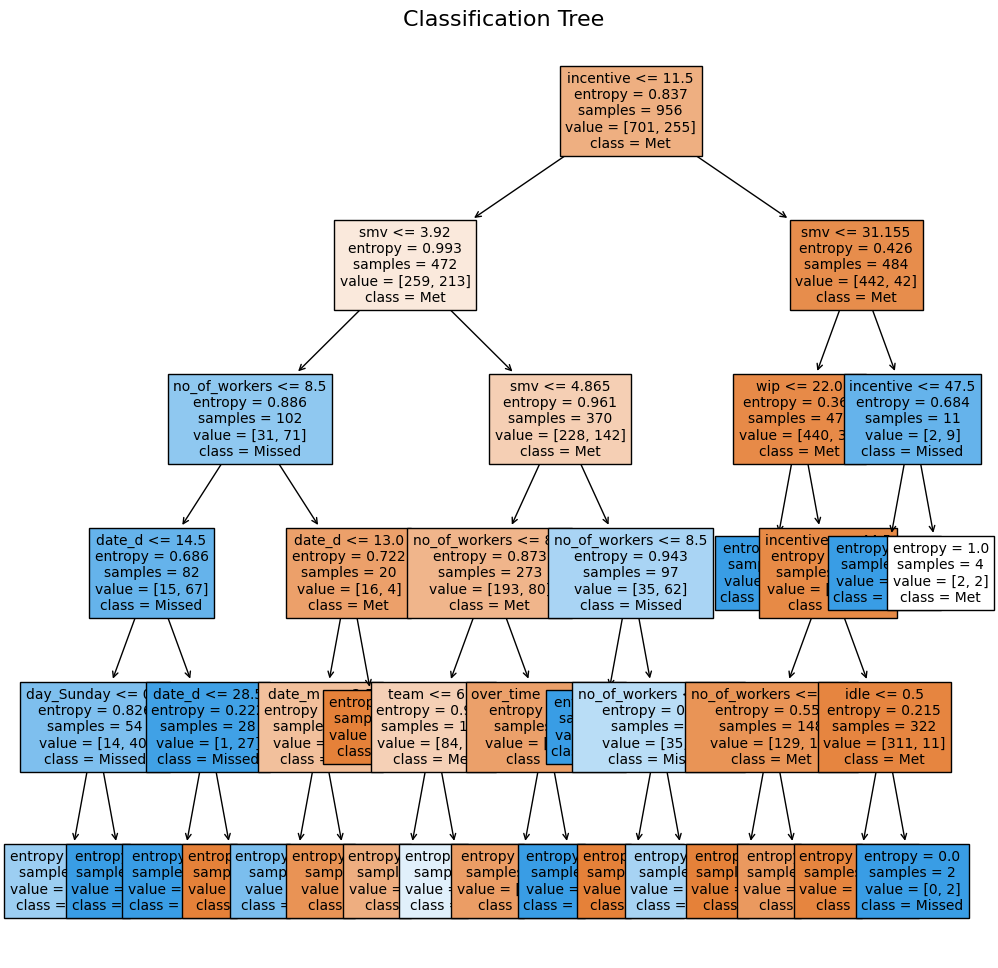

In [182]:
class_names = ['Met', 'Missed']

plt.figure(figsize=(12,12))
plot_tree(clf, feature_names=feature_names, filled=True, fontsize=10, class_names = class_names)
plt.title('Classification Tree', size=16)
plt.show()

Financial incentive for workers and smv (time allocated for a task) are the most important features.

Next we will try to improve the results by pruning the tree.

In [210]:
clf = DTC(criterion='entropy', random_state=20)
clf.fit(X_train, y_train)

# Extracting cost-complexity values (alphas and impurities)
ccp_path = clf.cost_complexity_pruning_path(X_train, y_train)

# CV for optimal values
kfold = skm.KFold(10,
                  random_state=30,
                  shuffle=True)

grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, y_train)

pruned_acc = accuracy_score(y_test, grid.best_estimator_.predict(X_test))
pruned_acc

0.8083333333333333

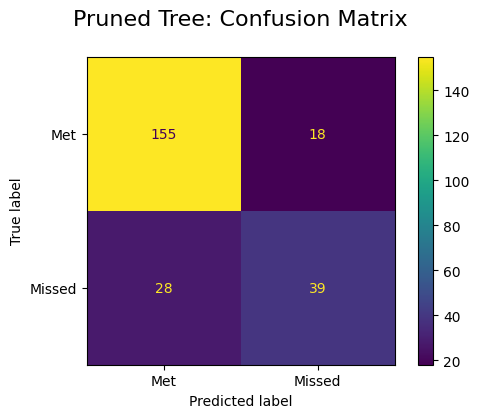

In [192]:
fig, ax = plt.subplots(figsize=(6, 4))
display = ConfusionMatrixDisplay.from_predictions(y_test, grid.best_estimator_.predict(X_test), ax=ax,
                                                 display_labels=class_names)
plt.title('Pruned Tree: Confusion Matrix'+'\n', size=16)
plt.show()

In [251]:
eval_metrics['Pruned Tree'] = [pruned_acc, 39/67]
eval_metrics

,Benchmark,Tree,Pruned Tree
Accuracy,0.72,0.766667,0.808333
Precision,0.28,0.641791,0.582090


The pruned tree achieved better accuracy at the expense of precision.

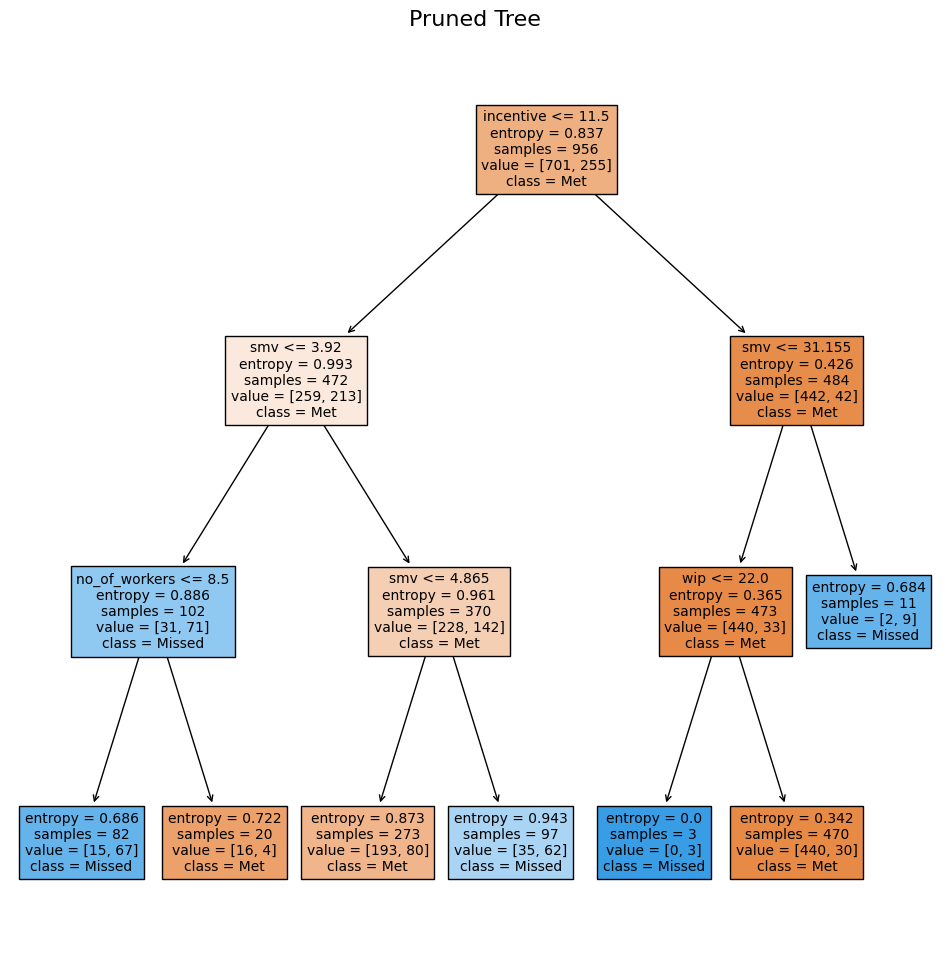

In [212]:
plt.figure(figsize=(12,12))
plot_tree(grid.best_estimator_, feature_names=feature_names,
          filled=True, fontsize=10, class_names=class_names)
plt.title('Pruned Tree', size=16)
plt.show()

Next, we will use ensemble techniques to find the best predictive model.

## Bagging and Random Forests

In [113]:
from sklearn.ensemble import RandomForestClassifier as RF

In [213]:
bag = RF(max_features=X.shape[1], n_estimators=500, random_state=20)
bag.fit(X_train, y_train)

bag_acc = accuracy_score(y_test, bag.predict(X_test))
bag_acc

0.8041666666666667

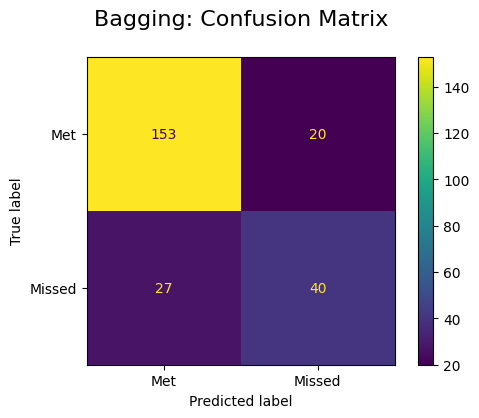

In [214]:
fig, ax = plt.subplots(figsize=(6, 4))
display = ConfusionMatrixDisplay.from_predictions(y_test, bag.predict(X_test), ax=ax,
                                                 display_labels=class_names)
plt.title('Bagging: Confusion Matrix'+'\n', size=16)
plt.show()

In [252]:
eval_metrics['Bagging'] = [bag_acc, 40/67]
eval_metrics

,Benchmark,Tree,Pruned Tree,Bagging
Accuracy,0.72,0.766667,0.808333,0.804167
Precision,0.28,0.641791,0.582090,0.597015


Bagging did not lead to better results in terms of accuracy and precision.

Next, we try a random forest with 4 features.

In [216]:
rf = RF(max_features=4, n_estimators=500, random_state=20)
rf.fit(X_train, y_train)

accuracy_score(y_test, rf.predict(X_test))

0.7916666666666666

Random forest shows the same result as bagging. We can try to evaluate the model with different number of features.

In [218]:
rf_acc = []
for f in range(1, 17):
    rf = RF(max_features=f, n_estimators=500, random_state=20)
    rf.fit(X_train, y_train)
    
    test_acc = accuracy_score(y_test, rf.predict(X_test))
    rf_acc.append(test_acc)

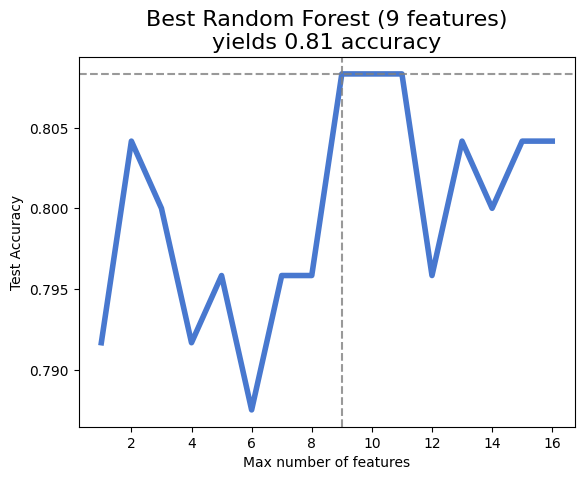

In [221]:
max_acc_n = np.argmax(rf_acc)+1
max_acc = round(np.max(rf_acc), 2)

plt.plot(range(1, 17), rf_acc, linewidth=4)
plt.axvline(max_acc_n, ls='--', c='gray', alpha=0.8)
plt.axhline(np.max(rf_acc), ls='--', c='gray', alpha=0.8)

plt.xlabel('Max number of features')
plt.ylabel('Test Accuracy')

plt.title(f'Best Random Forest ({max_acc_n} features)'+'\n'+f'yields {max_acc} accuracy', size=16)

plt.show()

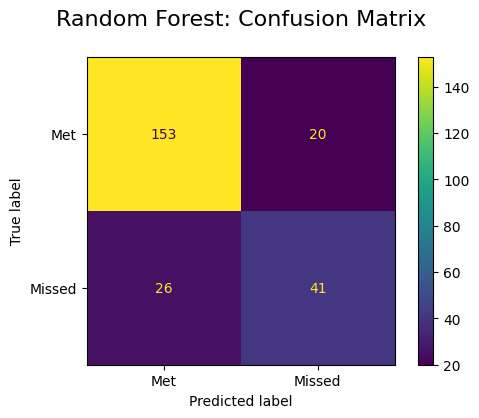

In [222]:
best_rf = RF(max_features=9, n_estimators=500, random_state=20)

best_rf.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(6, 4))
display = ConfusionMatrixDisplay.from_predictions(y_test, best_rf.predict(X_test), ax=ax,
                                                  display_labels=class_names)
plt.title('Random Forest: Confusion Matrix'+'\n', size=16)
plt.show()

In [253]:
best_rf_acc = accuracy_score(y_test, best_rf.predict(X_test))
eval_metrics['RF'] = [best_rf_acc, 41/67]
eval_metrics

,Benchmark,Tree,Pruned Tree,Bagging,RF
Accuracy,0.72,0.766667,0.808333,0.804167,0.808333
Precision,0.28,0.641791,0.582090,0.597015,0.611940


Random Forest with a maximum of 9 features and 500 estimators correctly predicts 41 out of 67 missed cases (61%).

## Gradient Boosting Classifier

Next, we use the Gradient Boosting Classifier.

In [47]:
from sklearn.ensemble import GradientBoostingClassifier as GBC

In [226]:
kfold = skm.KFold(5,
                  random_state=30,
                  shuffle=True)

grid_params = {'n_estimators' : [500, 1000, 3000],
               'learning_rate' : [0.1, 0.01, 0.001],
               'max_depth' : [1, 2, 3]}

gbc = GBC(random_state=20)

grid = skm.GridSearchCV(gbc,
                        grid_params,
                        refit=True,
                        cv=kfold,
                        scoring='accuracy',
                        n_jobs=-1)

grid.fit(X_train, y_train)

gbc_acc = accuracy_score(y_test, grid.best_estimator_.predict(X_test))

In [227]:
grid.best_params_

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}

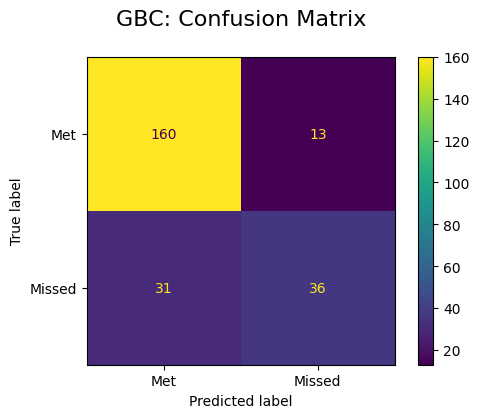

In [228]:
fig, ax = plt.subplots(figsize=(6, 4))
display = ConfusionMatrixDisplay.from_predictions(y_test, grid.best_estimator_.predict(X_test), ax=ax,
                                                 display_labels=class_names)
plt.title('GBC: Confusion Matrix'+'\n', size=16)
plt.show()

In [254]:
eval_metrics['GBC'] = [gbc_acc, 36/67]
eval_metrics = round(eval_metrics, 2)*100

eval_metrics

,Benchmark,Tree,Pruned Tree,Bagging,RF,GBC
Accuracy,72.0,77.0,81.0,80.0,81.0,82.0
Precision,28.0,64.0,58.0,60.0,61.0,54.0


In [255]:
benchmark = eval_metrics['Benchmark']
eval_metrics = eval_metrics.drop(['Benchmark'], axis=1)

The gradient boosting classifier with 1000 estimators, a learning rate of 0.01, and a maximum depth of 3 has a superior accuracy of 82%, but correctly predicts only 36 out of 67 missed cases (54%).

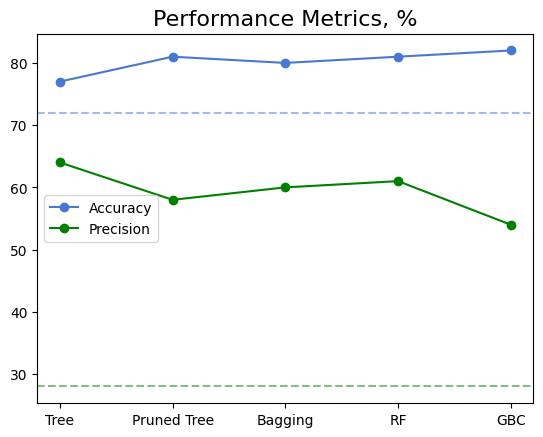

In [275]:
plt.plot(eval_metrics.T['Accuracy'], marker='o', label='Accuracy')
plt.axhline(benchmark.T['Accuracy'], ls='--', alpha=0.5)

plt.plot(eval_metrics.T['Precision'], marker='o', label='Precision', c='g')
plt.axhline(benchmark.T['Precision'], ls='--', c='g', alpha=0.5)

plt.legend()
plt.title('Performance Metrics, %', size=16)
plt.show()

GBC delivers best accuracy of 82%, while a simple tree has the best precision of 64%. Random forest looks like good choice on average. The final choice of the model would therefore depend on the business task at hand.

## Exploring the Features Importance

In [267]:
feature_imp = pd.DataFrame(
    {'importance': grid.best_estimator_.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False).head(5)

,importance
incentive,0.342420
smv,0.199376
no_of_workers,0.136498
wip,0.085077
over_time,0.061446


Incentive is the most important factor for goal attainment, followed by SMV (time allocated to the task) and the number of workers in the team.

Next, we explore how these characteristics affect the outcome using partial dependence plots.

In [51]:
from sklearn.inspection import PartialDependenceDisplay

In [269]:
# Fitting an optimal model on the full data set
gbc = GBC(max_depth=3, learning_rate=0.01,
          n_estimators=1000, random_state=20)

gbc.fit(X, y)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=20)

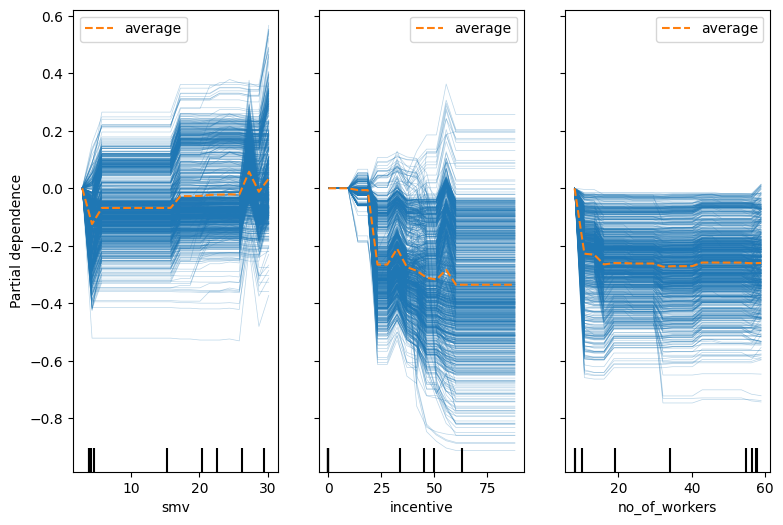

In [274]:
# Specifying features for PDP
features = [1, 4, 6]

fig, ax = plt.subplots(figsize=(9, 6))
display = PartialDependenceDisplay.from_estimator(
        gbc,
        X,
        features,
        kind='both',
        n_jobs=3,
        grid_resolution=20,
        centered=True,
        ax=ax)

# Setting the names of the x-axis for each plot
for ax, feature_idx in zip(display.axes_.ravel(), features):
    ax.set_xlabel(feature_names[feature_idx])

plt.show()

On average, increasing the amount of financial incentive and the number of workers in the team initially reduces the probability of missing the productivity target, but only up to a certain threshold. Increasing the amount of time allocated to a task is associated with a slightly higher probability of missing the target.

# Conclusion

This project set out with the objective of predicting the productivity performance of teams in the garment manufacturing industry, aiming to provide actionable insights for enhancing operational efficiency. Employing a dataset with rich features, we applied various machine learning techniques, including Decision Trees, Random Forests, and Gradient Boosting Classifiers, optimized through meticulous hyperparameter tuning.

Our findings underscore the significant impact of financial incentives, allocated task time (SMV), and team size on achieving productivity targets. The Gradient Boosting Classifier emerged as the most accurate model, achieving an 82% success rate in predicting productivity outcomes. However, the Decision Tree model exhibited superior precision (64%) in identifying instances where targets would not be met, highlighting its potential utility in risk mitigation scenarios.

A notable observation is the diminishing returns on increasing financial incentives and team size, suggesting an optimal threshold for these factors. This insight is particularly valuable for decision-makers in the industry, as it guides resource allocation and workforce management strategies.

While our analysis provides a robust foundation for understanding productivity dynamics in garment manufacturing, it also opens avenues for further research. Future studies could explore the interactions between these variables in more depth or apply our methodology to other sectors.

In conclusion, this project not only demonstrates the applicability of machine learning in operational optimization but also provides a practical framework for data-driven decision-making in the garment manufacturing industry. As we navigate the complexities of workforce management, these insights will be instrumental in shaping more efficient and productive operational strategies.